Regression - speed per frame  
Metric - Mean Squared Error

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

In [3]:
PATH = Path('../data/speedchallenge/')

# Data

## Video to image files

In [ ]:
# convert video to images by framerate (-r)
# ffmpeg -i train.mp4 -r 20 images/output_%05d.png

In [4]:
files = sorted(os.listdir(PATH/'train'))
speeds = np.loadtxt(PATH/'train.txt')
df = DataFrame({'filenames': files, 'labels': speeds})

test_df = DataFrame({'filenames': sorted(os.listdir(PATH/'test'))})
print(len(df), len(test_df))

20400 10798


In [5]:
speeds

array([28.105569, 28.105569, 28.106527, 28.130404, ...,  2.289795,  2.292917,  2.2606  ,  2.206759])

### Plot MSE with added gaussian noise

In [42]:
targs = torch.tensor(speeds)

In [43]:
# rand = np.random.normal(0,4.6,len(speeds))
rand = 4.6

In [44]:
mse(targs+rand, targs)

tensor(21.1600, dtype=torch.float64)

In [45]:
x = np.arange(len(targs))

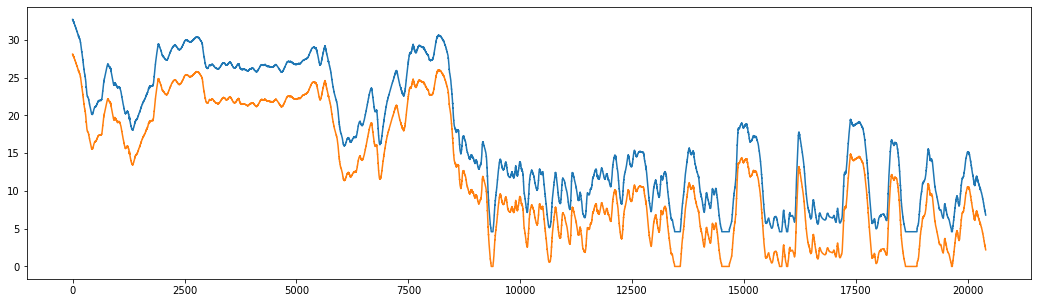

In [46]:
plt.figure(figsize=(18,5))
plt.plot(x, targs+rand)
plt.plot(x, targs)

## Get tensors directly from video (torchvision.io)

In [352]:
from torchvision.io import read_video

In [354]:
%time vframes,_,_ = read_video(PATH/'flow0.mp4', pts_unit='sec')

ValueError: File object has no read method.

In [7]:
vframes.shape

torch.Size([20400, 480, 640, 3])

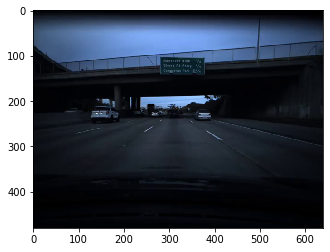

In [28]:
plt.imshow(vframes[0])

In [23]:
# resize to 224
out = F.interpolate(vframes[:10].permute(0,3,1,2).float(), size=(224))
out.shape

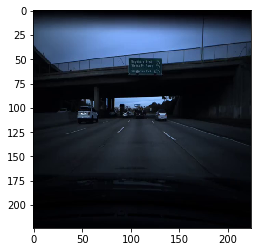

In [27]:
plt.imshow(out[0].permute(1,2,0).byte())

## Sequential Databunch

In [6]:
tfms = ([flip_lr(p=0.5,use_on_y=False)],[])

In [ ]:
class Model(Module):
    def __init__(self, top_speed=30):
        self.max = top_speed
        self.body = nn.Sequential(*list(models.xresnet18_deep().children()))[:-1]
        self.lstm = nn.LSTM(256,32,1,batch_first=True, bidirectional=True)
        self.lin = nn.Linear(64,1)
        
    def forward(self, x):
        x = self.body(x)
        x,_ = self.lstm(x.view(10,100,-1))
        x = self.lin(x.reshape(1000,-1))
        return torch.clamp(x,0,self.max)

In [97]:
learn.load()

In [102]:
def label_collater(samples:BatchSamples, seq_len=100):
    data = to_data(samples)
    
    
    
#     X = train[feats].values.reshape(-1, seq_len, len(feats))
#     Y = train['open_channels'].values.reshape(-1, seq_len)

    ims, lbls = zip(*data)
    pdb.set_trace()
    imgs = torch.stack(list(ims))
    labels = torch.from_numpy(np.stack(lbls))
    return imgs,labels
    
    
#     if len(data) is 1 and lbls[0] is 0:   #predict
#         labels = torch.zeros(1,1).long()
#         return imgs, labels    
#     max_len = max([len(s) for s in lbls])
#     labels = torch.zeros(len(data), max_len+1).long() + pad_idx  # add 1 to max_len to account for bos token
#     for i,lbl in enumerate(lbls):
#         labels[i,:len(lbl)] = torch.from_numpy(lbl)  #padding end    
#     return imgs, labels

In [104]:
data = (ImageList.from_df(df, PATH/'train', convert_mode='L')
        .split_none()
        .label_from_df()
        .transform([])#, size=(64,128))  # no dynamic resizing; use small dataset
        .add_test(ImageList.from_df(test_df, PATH, convert_mode='L'))
        .databunch(bs=100) )

data.train_dl = data.train_dl.new(shuffle=False)

In [105]:
itr = iter(data.train_dl)

In [117]:
x,y = next(itr)

In [122]:
speeds[130]

25.985965

In [123]:
y.view(10,-1).shape

torch.Size([10, 10])

In [118]:
y

tensor([26.5019, 26.5085, 26.4564, 26.4609, 26.4471, 26.4447, 26.4322, 26.3490,
        26.3684, 26.3287, 26.2872, 26.2867, 26.2731, 26.2588, 26.2640, 26.2165,
        26.2291, 26.2054, 26.1850, 26.1877, 26.1637, 26.1151, 26.1158, 26.1069,
        26.0937, 26.0267, 26.0597, 26.0435, 26.0270, 26.0364, 25.9860, 25.8828,
        25.8485, 25.9231, 25.8982, 25.9367, 25.8894, 25.8810, 25.8836, 25.8387,
        25.8373, 25.7601, 25.7266, 25.7050, 25.6928, 25.6946, 25.7157, 25.7211,
        25.7101, 25.6751, 25.6904, 25.6593, 25.5885, 25.5876, 25.6051, 25.5470,
        25.5616, 25.5200, 25.5129, 25.5359, 25.4668, 25.4682, 25.4430, 25.4347,
        25.4157, 25.3762, 25.3803, 25.3167, 25.3080, 25.3079, 25.2579, 25.2342,
        25.2345, 25.1646, 25.1555, 25.1246, 25.0519, 25.0696, 24.9848, 24.9677,
        24.9892, 24.9201, 24.8787, 24.7815, 24.8134, 24.7650, 24.7032, 24.7190,
        24.6169, 24.5995, 24.5837, 24.4783, 24.4466, 24.4259, 24.3342, 24.2774,
        24.2438, 24.1661, 24.1700, 24.06

In [98]:
data.show_batch(5)

> <ipython-input-92-d6e88ff008b6>(3)label_collater()
-> data = to_data(samples)
(Pdb) samples
[(Image (1, 480, 640), FloatItem 28.10557), (Image (1, 480, 640), FloatItem 28.10557), (Image (1, 480, 640), FloatItem 28.106527), (Image (1, 480, 640), FloatItem 28.130404), (Image (1, 480, 640), FloatItem 28.109243), (Image (1, 480, 640), FloatItem 28.088572), (Image (1, 480, 640), FloatItem 28.03421), (Image (1, 480, 640), FloatItem 28.018492), (Image (1, 480, 640), FloatItem 27.986624), (Image (1, 480, 640), FloatItem 28.016352), (Image (1, 480, 640), FloatItem 27.981985), (Image (1, 480, 640), FloatItem 27.978624), (Image (1, 480, 640), FloatItem 28.032331), (Image (1, 480, 640), FloatItem 27.960218), (Image (1, 480, 640), FloatItem 27.937178), (Image (1, 480, 640), FloatItem 27.9406), (Image (1, 480, 640), FloatItem 27.908579), (Image (1, 480, 640), FloatItem 27.898605), (Image (1, 480, 640), FloatItem 27.855982), (Image (1, 480, 640), FloatItem 27.795582), (Image (1, 480, 640), FloatIte

(Pdb) n
> <ipython-input-92-d6e88ff008b6>(7)label_collater()
-> X = train[feats].values.reshape(-1, seq_len, len(feats))
(Pdb) data
[[tensor([[[0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
         [0.0118, 0.0118, 0.0118,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0078, 0.0078, 0.0078,  ..., 0.0118, 0.0118, 0.0118],
         [0.0078, 0.0078, 0.0078,  ..., 0.0118, 0.0118, 0.0118],
         [0.0078, 0.0078, 0.0078,  ..., 0.0118, 0.0118, 0.0118]]]), array(28.10557, dtype=float32)], [tensor([[[0.0078, 0.0078, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
         [0.0118, 0.0118, 0.0118,  ..., 0.0000, 0.0000, 0.0000],
         [0.0196, 0.0196, 0.0196,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078],
         [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078],
         [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078]]]), array(28.10557, dt

(Pdb) data.shape
*** AttributeError: 'list' object has no attribute 'shape'
(Pdb) q


BdbQuit: 

## ImagePair DataBunch

In [898]:
class ImagePairList(ImageList):
    _label_cls=None
    
    def get(self, i):
        im2 = super().get(i)
        im1 = super().get(i-1)
        # crop out dash and roof and concatenate images vertically
        res = torch.cat([im1.data, im2.data], dim=1)
        return Image(res)

In [ ]:
def denseOptFlow(prv, nxt):
    "Input grayscale numpy arrays"
    # params = {prev, next, flow, pyr_scale, levels, winsize, iterations, poly_n, poly_sigma, flags=0}
    flow = cv2.calcOpticalFlowFarneback(prv, nxt, None, 0.5, 1, 5, 1, 5, 1.1, 0)
    #flow = cv2.calcOpticalFlowFarneback(prv,nxt, None, 0.5, 3, 15, 3, 5, 1.2, 0)  #ex from opencv docs
    # => optical flow vectors (2 channels)
                              
    # convert from cartesian to polar to get magnitude and angle of flow vectors
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])  
        
    hue = ang * (180/ np.pi / 2)   # hue corresponds to direction  max=180
    sat = np.zeros_like(nxt, dtype= np.float32) + 255   # set saturation to constant
    val = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)   # value corresponds to magnitude normalized to 0-255
        
    hsv = np.stack([hue,sat,val], axis=-1)
    return cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)

def open_flow(x):
    "Convert cv2 image into torch.tensor and normalize"
    x = torch.from_numpy(np.transpose(x, (2,0,1)))
    #x = torch.clamp(x, 0, 255)
    return x.div(255)

In [910]:
def _flow_img(x):
    flow = denseOptFlow(*torch.chunk(x,2,1))  # split vertically into separate images
    return open_flow(flow)
#     if isinstance(x, ImagePoints):
#         x.flow.flow[...,0] *= -1
#         return x
#     return tensor(np.ascontiguousarray(np.array(x)[...,::-1]))
flow_img = TfmPixel(_flow_img)

In [911]:
tfms = ([flip_lr(p=0.5,use_on_y=False),
brightness(change=(0.3, 0.7), p=0.75, use_on_y=False),
contrast(scale=(0.6, 1.6), p=0.75, use_on_y=False),
flow_img()], [flow_img()])

In [912]:
data = (ImagePairList.from_df(df, PATH/'train', convert_mode='L')
       .split_by_rand_pct(seed=42)
       .label_from_df()
       .transform(tfms)#, size=(64,128))
       .databunch(bs=32, num_workers=1)
      )

--Return--
> <ipython-input-910-24ec08885f92>(3)_flow_img()->None
-> pdb.set_trace()
(Pdb) prv.shape
torch.Size([1, 480, 640])
(Pdb) prv.squeeze().numpy()
array([[0.005314, 0.005314, 0.005314, 0.005314, ..., 0.010613, 0.010613, 0.010613, 0.010613],
       [0.005314, 0.005314, 0.005314, 0.005314, ..., 0.010613, 0.010613, 0.010613, 0.010613],
       [0.005314, 0.005314, 0.005314, 0.005314, ..., 0.010613, 0.010613, 0.010613, 0.010613],
       [0.005314, 0.005314, 0.005314, 0.005314, ..., 0.015898, 0.015898, 0.015898, 0.015898],
       ...,
       [0.021167, 0.021167, 0.021167, 0.021167, ..., 0.026422, 0.026422, 0.026422, 0.026422],
       [0.021167, 0.021167, 0.021167, 0.021167, ..., 0.026422, 0.026422, 0.026422, 0.026422],
       [0.021167, 0.021167, 0.021167, 0.021167, ..., 0.026422, 0.026422, 0.026422, 0.026422],
       [0.021167, 0.021167, 0.021167, 0.021167, ..., 0.021167, 0.021167, 0.021167, 0.021167]], dtype=float32)
(Pdb) q


Exception: It's not possible to apply those transforms to your dataset:
 

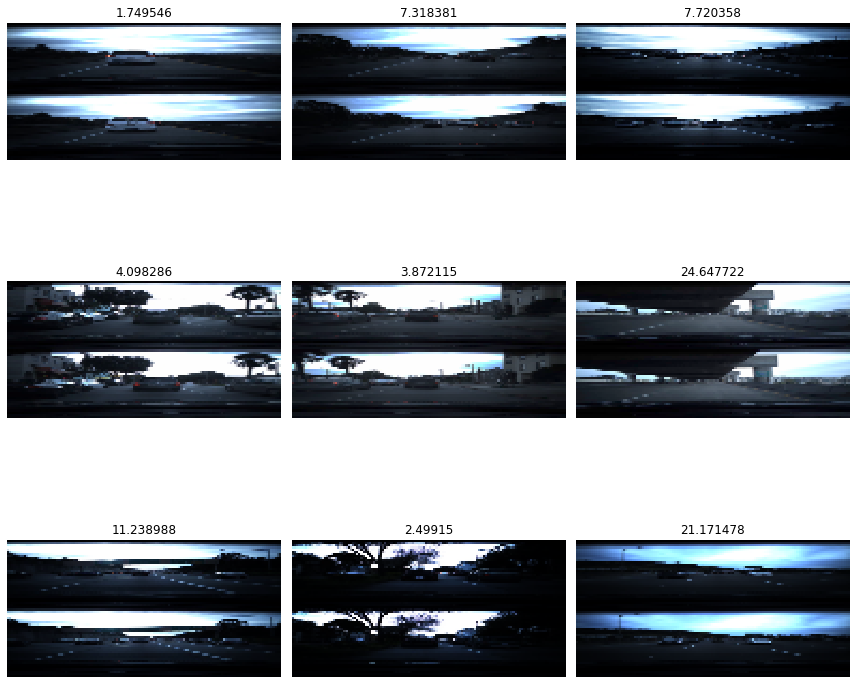

In [900]:
data.show_batch(rows=3)

## ImageList Databunch

In [23]:
data = (ImageList.from_df(df, PATH/'train')
        .split_by_rand_pct(seed=42)
        .label_from_df()
        .transform([], size=(64,128))
        .add_test(ImageList.from_df(test_df, PATH/'test'))
        .databunch(bs=100)
       )

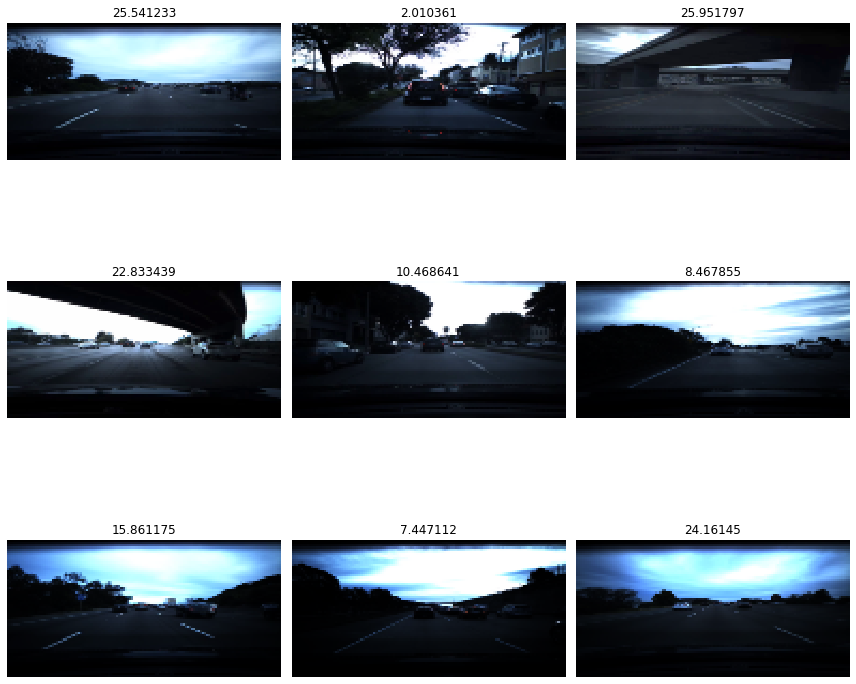

In [717]:
data.show_batch(rows=3)

## Model

In [24]:
class Model(Module):
    def __init__(self, top_speed=30):
        self.max = top_speed
        self.body = models.xresnet18_deep(c_out=1)#nn.Sequential(*list(models.xresnet34().children())[:-4])
        
    def forward(self, x):
        x = self.body(x)
        return torch.clamp(x, 0, self.max)

In [26]:
learn = Learner(data, Model(), loss_func=MSELossFlat(), metrics=[accuracy])

In [248]:
learn.lr_find()
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


KeyboardInterrupt: 

# Dense Optical Flow and Phase Correlation

In [160]:
# https://github.com/jovsa/speed-challenge-2017/blob/master/NVIDIA_model.ipynb

def denseOpticalFlow(image_current, image_next):
    """
    input: image_current, image_next (RGB images)
    calculates optical flow magnitude and angle and places it into HSV image
    * Set the saturation to the saturation value of image_next
    * Set the hue to the angles returned from computing the flow params
    * set the value to the magnitude returned from computing the flow params
    * Convert from HSV to RGB and return RGB image with same size as original image
    """
    gray_current = cv2.cvtColor(image_current, cv2.COLOR_RGB2GRAY)
    gray_next = cv2.cvtColor(image_next, cv2.COLOR_RGB2GRAY)
    
    
    hsv = np.zeros_like(image_next) # (length,width,3): [hue,saturation,value]
    # set saturation
    hsv[:,:,1] = cv2.cvtColor(image_next, cv2.COLOR_RGB2HSV)[:,:,1]
 
    # obtain dense optical flow paramters
    flow = cv2.calcOpticalFlowFarneback(gray_current, gray_next,  
                                        flow_mat=None,#cv2.CV_32FC2,
                                        image_scale=0.5, 
                                        nb_images=1, 
                                        win_size=15, 
                                        nb_iterations=2, 
                                        deg_expansion=5, 
                                        STD=1.3, 
                                        extra=0
                                       )
                                        
        
    # convert from cartesian to polar to get magnitude and angle of flow diffs
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])  
        
    # hue corresponds to direction
    hsv[:,:,0] = ang * (180/ np.pi / 2)
    
    # value corresponds to magnitude
    hsv[:,:,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    
    # convert HSV to float32's
    hsv = np.asarray(hsv, dtype= np.float32)
    rgb_flow = cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)

    return rgb_flow

In [26]:
df.head()

filenames     labels
0  output_00001.png  28.105569
1  output_00002.png  28.105569
2  output_00003.png  28.106527
3  output_00004.png  28.130404
4  output_00005.png  28.109243

In [27]:
diffs = []
for i in range(len(files)):
    im1 = open_image(PATH/files[i-1])
    im2 = open_image(PATH/files[i])
    diffs.append(((im2.data - im1.data)**2).sum().sqrt())

In [28]:
len(diffs)

20400

In [33]:
diff = [d.item() for d in diffs]

In [41]:
df['diffs'] = diff

In [40]:
diff[0] = 46.41794967651367

In [42]:
df.head()

filenames     labels      diffs
0  output_00001.png  28.105569  46.417950
1  output_00002.png  28.105569  44.103661
2  output_00003.png  28.106527  46.417950
3  output_00004.png  28.130404  44.274014
4  output_00005.png  28.109243  53.793743

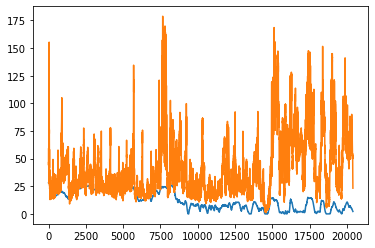

In [43]:
x = np.arange(len(df))
plt.plot(x,df.labels)
plt.plot(x,df.diffs)

In [23]:
im1 = open_image(PATH/'output_00002.png')
im2 = open_image(PATH/'output_00001.png')

In [24]:
((im2.data - im1.data)**2).sum().sqrt()  # L2 norm of the difference

tensor(44.1037)

In [61]:
from scipy.fftpack import fftn, ifftn
corr = (ifftn(fftn(im1.data.numpy())*ifftn(im2.data.numpy()))).real

In [62]:
corr.shape

(3, 480, 640)

In [42]:
def phase_correlation(a, b):
    G_a = np.fft.fft2(a)
    G_b = np.fft.fft2(b)
    conj_b = np.ma.conjugate(G_b)
    R = G_a*conj_b
    R /= np.absolute(R)
    r = np.fft.ifft2(R).real
    return r

In [44]:
res = phase_correlation(im1.data.numpy(),im2.data.numpy())

In [50]:
res.shape

(3, 480, 640)

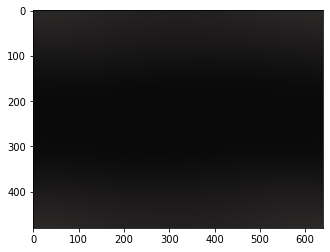

In [64]:
plt.imshow(corr.transpose(1,2,0))

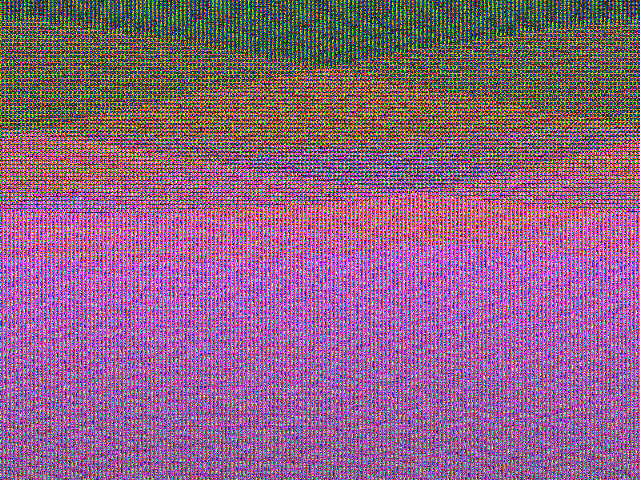

In [65]:
PIL.Image.fromarray(corr.transpose(1,2,0), 'RGB')

In [47]:
im1.shape

torch.Size([3, 480, 640])

# Transforms

In [222]:
def get_ex(): 
    im1 = open_image(PATH/'output_00675.png')
    im2 = open_image(PATH/'output_00676.png')
    return Image(torch.cat([im1.data[:,50:300,:],im2.data[:,50:300,:]], dim=1))

def plots_f(rows, cols, width, height, **kwargs):
    [get_ex().apply_tfms(tfms[0], **kwargs).show(ax=ax) for i,ax in enumerate(plt.subplots(
        rows,cols,figsize=(width,height))[1].flatten())]

In [13]:
tfms = get_transforms(max_rotate=0, max_warp=0, max_lighting=0.3)

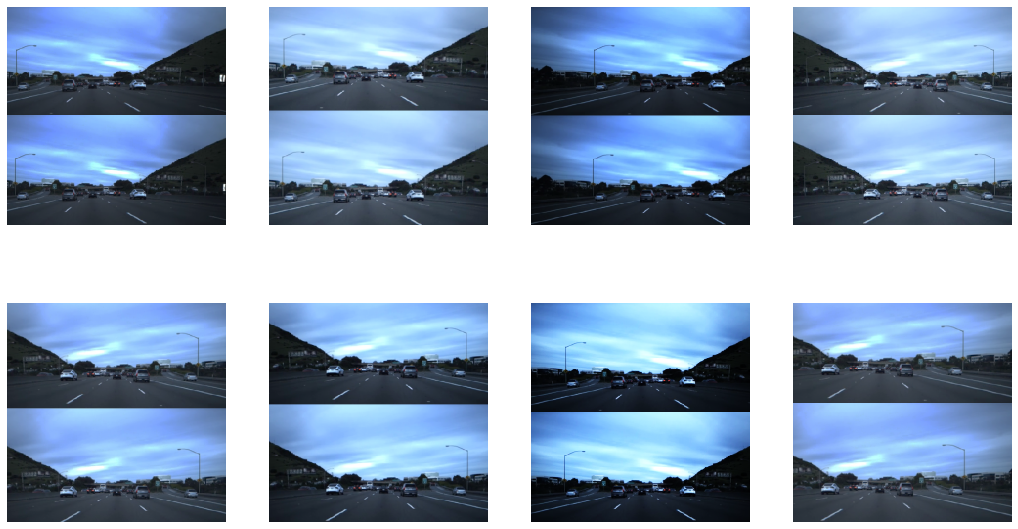

In [240]:
plots_f(2, 4, 18, 10, size=224)

# Verify from GPU

In [3]:
import matplotlib.ticker as mpl_ticker

In [4]:
def show_lines(start=0,stop=-1,step=1,cols=[],time=True,ticks=600):
    fig, ax = plt.subplots(figsize=(18,5))
    ax.grid(which='both', axis='both')
    
    # this locator puts ticks at regular intervals
    loc = mpl_ticker.MultipleLocator(base=ticks)
    ax.xaxis.set_major_locator(loc)
    
    # this formats the ticks with a lambda
    if time: ax.xaxis.set_major_formatter(mpl_ticker.FuncFormatter(lambda x, pos: frame_time(x)))
    
    for col in cols:
        ax.plot(col[start:stop:step])

In [66]:
# 0th second lasts 10 frames
def time_frame(min,sec): return ((min*60)+sec)*20 - 10
def frame_time(frame):
    f = (frame+10)/20
    return(f'{int(f//60)}:{int(f%60)}')

### Verify trough placements with video

In [ ]:
#=> for frames ~1175-1620 speed is 0!!

# slow down and acceleration (trough)
# 4:34, 5:10, 5:34, 6:10, 6:31, 6:51-6:55, 7:27, 8:02, 8:09, 8:43
# 5480, 6200, 6680, 7400, 7820, 8220-8300, 8940, 9640, 9780, 10460

In [127]:
frame_time(7600)

'6:20'

In [289]:
time_frame(8,0)

9590

## Validation Predictions

In [8]:
val_preds = pd.read_csv(PATH/'val_preds10.csv')
df['preds'] = val_preds.preds.values[:20400]   # remove added test frames

df['rolling35'] = df.preds.rolling(35,center=True).mean()

# fill forward and backward
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)

In [9]:
mse(torch.from_numpy(df.preds.values), torch.from_numpy(df.labels.values))
# 0.3661  val_preds
# 0.4290  val_preds2
# 0.3588  val_preds3
# 0.7552  val_preds5
# 0.3531  val_preds6
# 0.1593  val_preds7
# 0.6046  val_preds8
# 0.2905  val_preds9
# 0.1706  val_preds10

# 0.0384  val_preds11

tensor(0.1706, dtype=torch.float64)

In [10]:
mse(torch.from_numpy(df['rolling35'].values), torch.from_numpy(df.labels.values))
# 0.0696  val_preds
# 0.1025  val_preds2
# 0.0780  val_preds3
# 0.1983  val_preds5
# 0.0727  val_preds6
# 0.0252  val_preds7
# 0.1348  val_preds8
# 0.0499  val_preds9
# 0.0290  val_preds10

# 0.0106  val_preds11

tensor(0.0290, dtype=torch.float64)

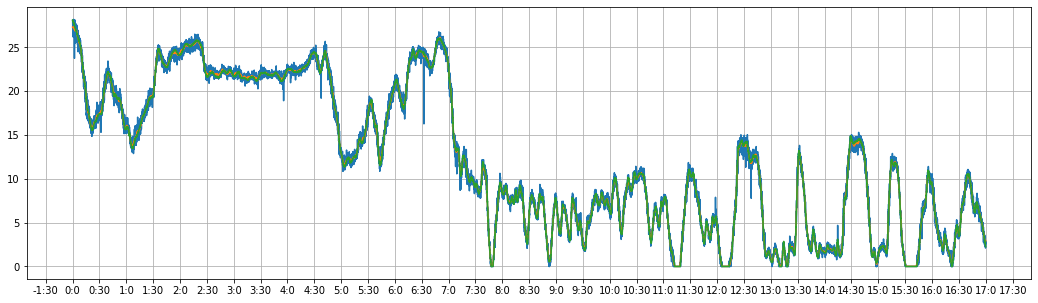

In [13]:
# val_preds10 - video to frames(128x256); flip_lr(); 10cycle; prog resizing from(64x128); histogram equalization
show_lines(cols=[df.preds, df.rolling35, df.labels])

In [635]:
mse(torch.from_numpy(rolling_ridge_regression(df.preds.values)), torch.from_numpy(df.labels.values))

tensor(0.0277, dtype=torch.float64)

### previous val_preds

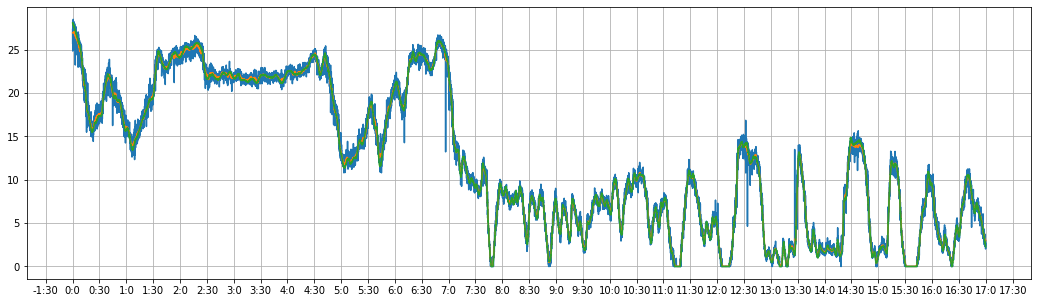

In [148]:
# val_preds9 - video to frames(128x256); flip_lr(); 10cycle; prog resizing from(64x128); clahe(25)
show_lines(cols=[df.preds, df.rolling35, df.labels])

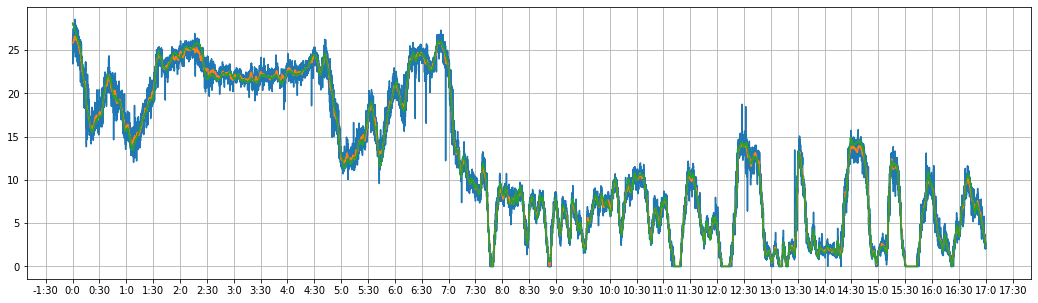

In [132]:
# val_preds8 - video to frames(64x128); flip_lr(); 10cycle; clahe(25)
show_lines(cols=[df.preds, df.rolling35, df.labels])

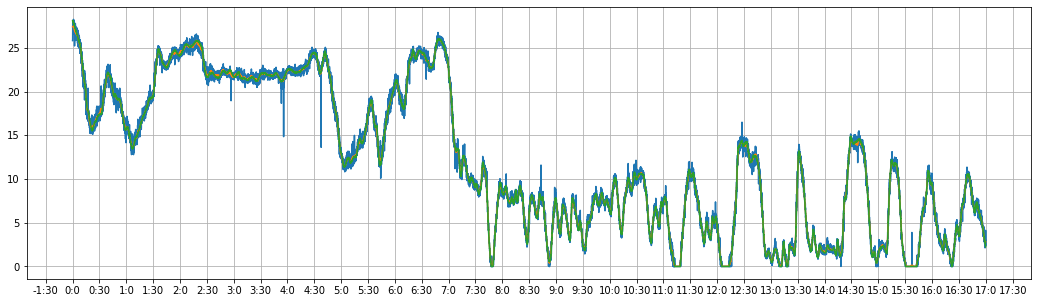

In [55]:
# val_preds7 - video to frames(128x256); flip_lr(); 10cycle; prog resizing (64x128); load saved models; valid_idxs
show_lines(cols=[df.preds, df.rolling35, df.labels])

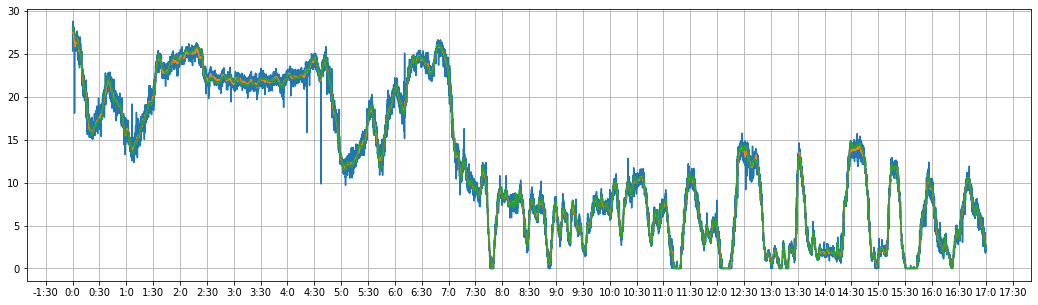

In [34]:
# val_preds6 - video to frames(64x128); flip_lr(); 10cycle
show_lines(cols=[df.preds, df.rolling35, df.labels])

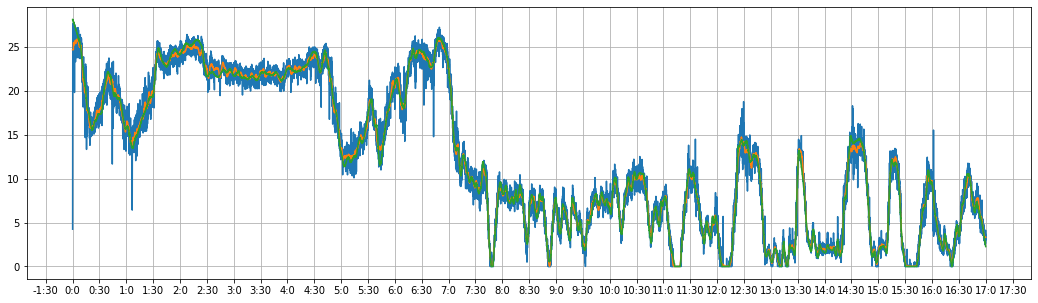

In [12]:
# val_preds5 - dynamic w/ augmentations
show_lines(cols=[df.preds, df.rolling35, df.labels])

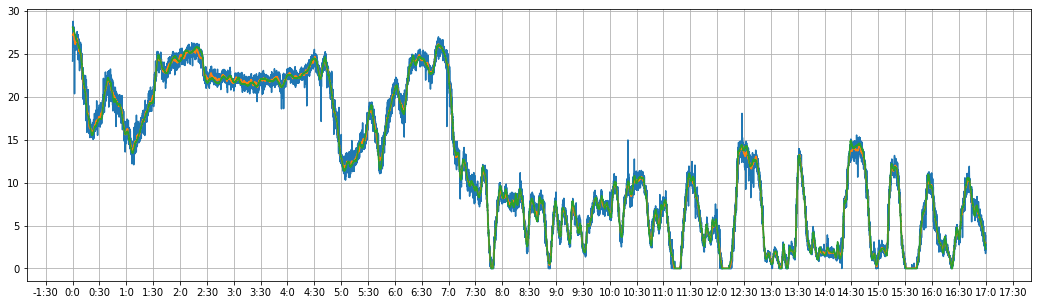

In [508]:
# val_preds3
show_lines(cols=[df.preds, df.rolling35, df.labels])

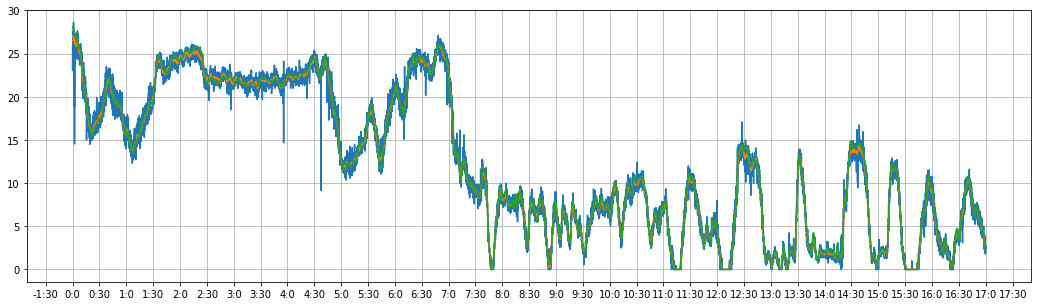

In [311]:
# val_preds2 - add test cross-flow traffic frames
show_lines(cols=[df.preds, df.rolling35, df.labels]) 

### Remove large rolling variances (w/ linear interpolation); rolling_mean(35)

In [216]:
df['rolling_var'] = df.preds.rolling(35,center=True).var()

# fill forward and backward
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)

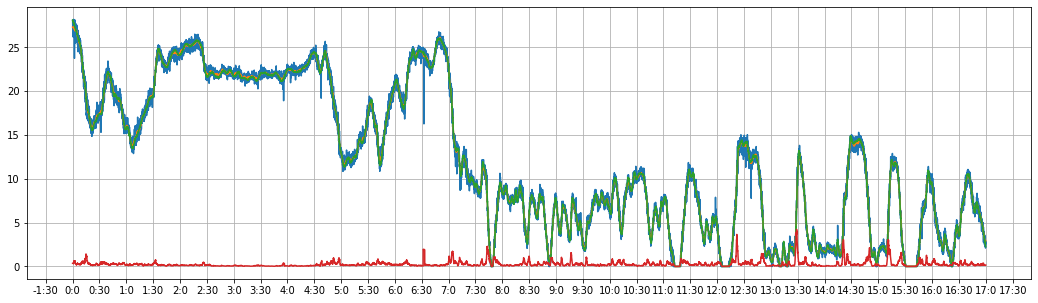

In [217]:
show_lines(cols=[df.preds, df.rolling35, df.labels, df.rolling_var])

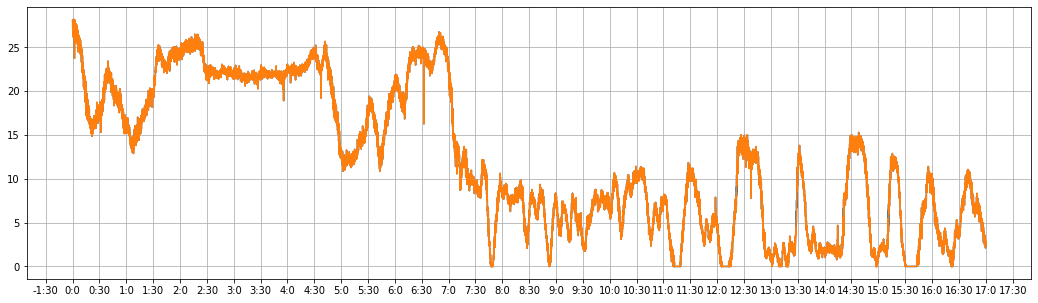

In [218]:
df['stable'] = np.where(df.rolling_var > 3, np.NaN, df.preds)
df.stable.interpolate(inplace=True)
show_lines(cols=[df.preds, df.stable])

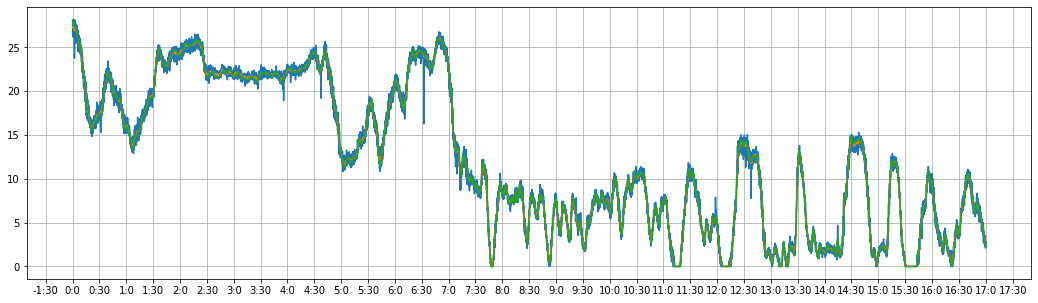

In [219]:
df['rolling35'] = df.stable.rolling(35,center=True).mean()

# fill forward and backward
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)

show_lines(cols=[df.stable, df.rolling35, df.labels])

In [220]:
mse(torch.from_numpy(df.rolling35.values), torch.from_numpy(df.labels.values))
# 0.0711  val_preds
# 0.0974  val_preds2
# 0.0780  val_preds3
# 0.1972  val_preds5
# 0.0717  val_preds6
# 0.0255  val_preds7
# 0.1440  val_preds8

# 0.0291  val_preds10

tensor(0.0291, dtype=torch.float64)

### Avg Change

In [74]:
df['diff'] = df.labels.diff()
df.fillna(method='bfill', inplace=True)

In [83]:
df['diff'].describe()

count    20400.000000
mean        -0.001270
std          0.056457
min         -0.340245
25%         -0.023428
50%         -0.000041
75%          0.018864
max          0.402927
Name: diff, dtype: float64

In [84]:
test_preds['diff'] = test_preds.rolling35.diff()
test_preds.fillna(method='bfill', inplace=True)
test_preds['diff'].describe()

count    10798.000000
mean         0.000062
std          0.071823
min         -0.321733
25%         -0.041391
50%          0.000000
75%          0.041694
max          0.254789
Name: diff, dtype: float64

In [85]:
test_preds

0          1          2          3          4        avg  \
0       9.065039   8.119929   7.550276   7.984497   8.458390   8.235626   
1       9.065039   8.119929   7.550276   7.984497   8.458390   8.235626   
2       9.112373   8.150160   7.052491   7.557563   7.320403   7.838598   
3       8.266492   7.931001   8.417159   8.787155   7.884547   8.257271   
4       8.816297   8.002753   8.401200  10.047953   9.776084   9.008857   
...          ...        ...        ...        ...        ...        ...   
10793  11.942235  10.979781  10.991415  10.690341  11.398616  11.200478   
10794  11.639050  11.530334  11.417749  10.745577  11.290636  11.324669   
10795  11.530396  12.311406  11.802302  11.282279  11.360909  11.657458   
10796  11.117689  13.039215  11.627084  11.411585  11.491040  11.737323   
10797  10.695672  12.571516  11.445766  11.170553  11.002065  11.377114   

       rolling_var     stable  rolling35  diff  
0         1.114650   8.235626   7.808905   0.0  
1         1.114650   8.235626   7.808905   0.0  
2         1.114650   7.838598   7.808905   0.0  
3         1.114650   8.257271   7.808905   0.0  
4         1.114650   9.008857   7.808905   0.0  
...            ...        ...        ...   ...  
10793     3.024809  11.200478   8.473265   0.0  
10794     3.024809  11.324669   8.473265   0.0  
10795     3.024809  11.657458   8.473265   0.0  
10796     3.024809  11.737323   8.473265   0.0  
10797     3.024809  11.377114   8.473265   0.0  

[10798 rows x 10 columns]

## Test Predictions

In [67]:
test_preds = pd.read_csv(PATH/'test_preds10.csv')
test_preds['avg'] = test_preds.mean(axis=1)   # take average of kfolds
len(test_preds)

10798

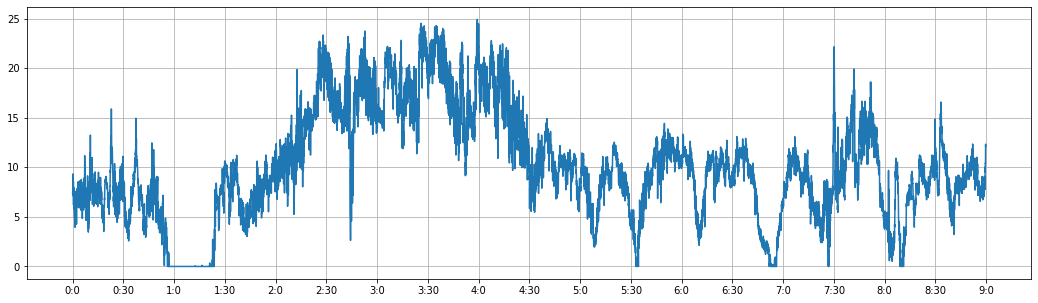

In [68]:
# test_preds10
show_lines(cols=[test_preds.avg])

### previous test_preds

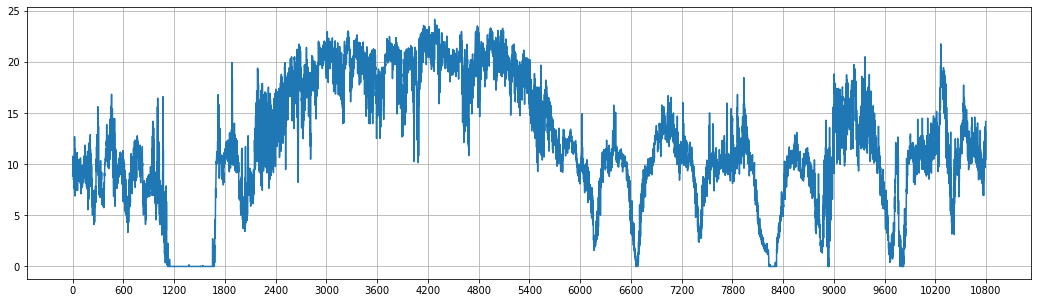

In [150]:
# test_preds9
show_lines(cols=[test_preds.avg], time=False)

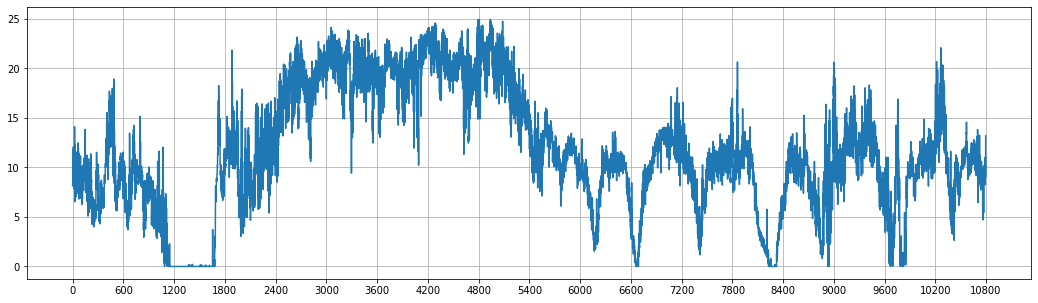

In [136]:
# test_preds8
show_lines(cols=[test_preds.avg], time=False)

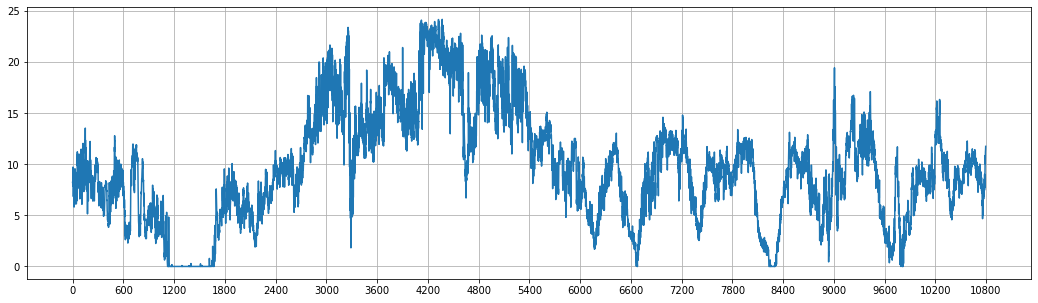

In [125]:
# test_preds7
show_lines(cols=[test_preds.avg], time=False)

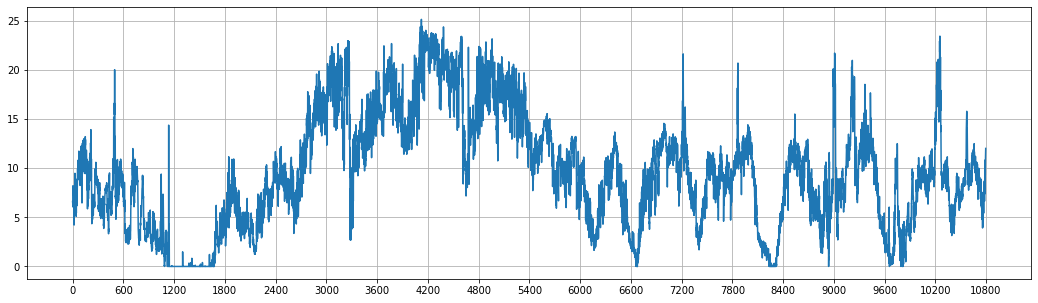

In [43]:
# test_preds6
show_lines(cols=[test_preds.avg], time=False)

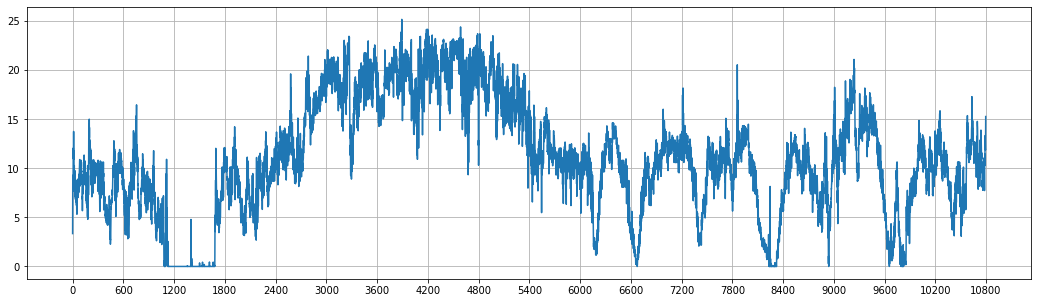

In [21]:
# test_preds5
show_lines(cols=[test_preds.avg], time=False)

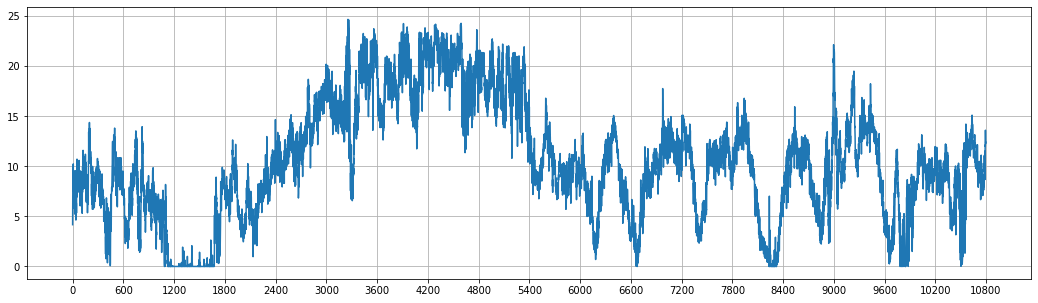

In [16]:
# test_preds4
show_lines(cols=[test_preds.avg], time=False)

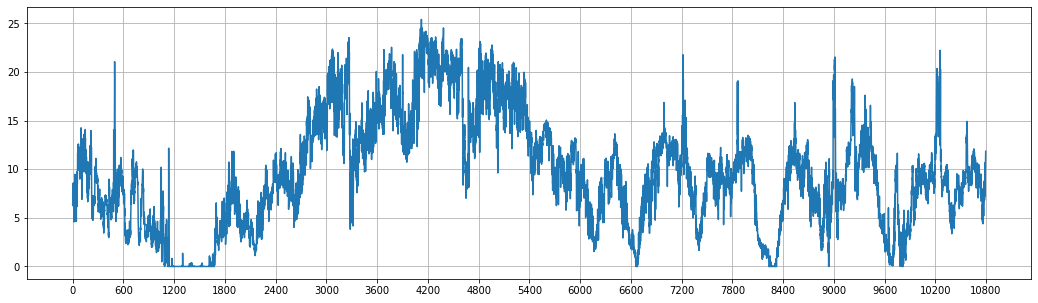

In [868]:
# test_preds3
show_lines(cols=[test_preds.avg], time=False)

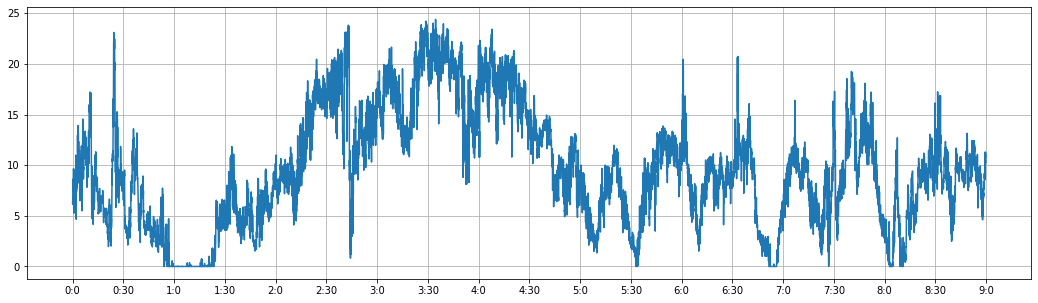

In [927]:
# test_preds2 (after adding cross-traffic test images to training set)
show_lines(cols=[test_preds.avg])

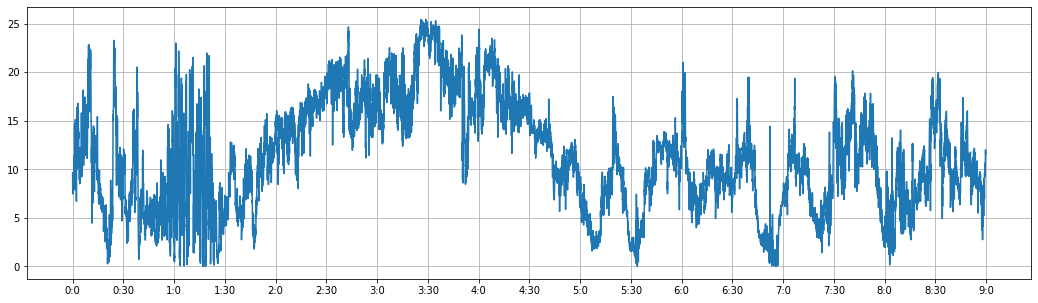

In [929]:
# test_preds (before adding cross-traffic test images to training)
show_lines(cols=[test_preds.avg])

### Remove and linearly interpolate areas with high variance

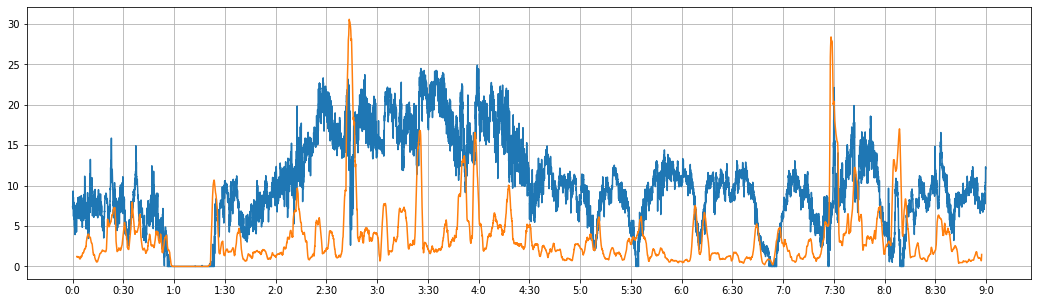

In [279]:
test_preds['rolling_var'] = test_preds.avg.rolling(100,center=True).var()
# test_preds.fillna(method='ffill', inplace=True)
# test_preds.fillna(method='bfill', inplace=True)
show_lines(cols=[test_preds.avg, test_preds.rolling_var])

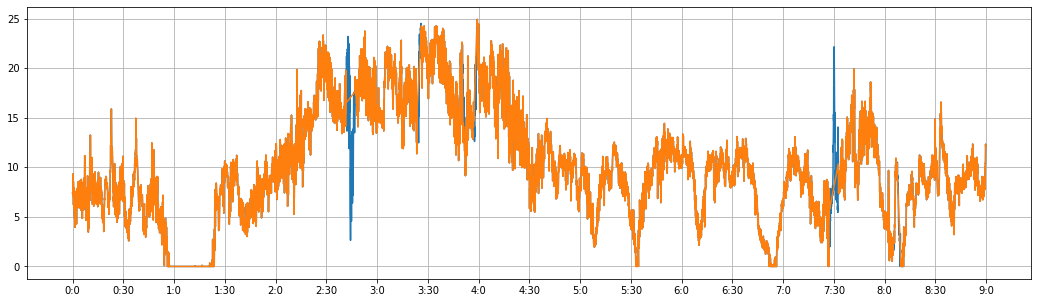

In [280]:
test_preds['stable'] = np.where(test_preds.rolling_var > 13, np.NaN, test_preds.avg)
test_preds.stable.interpolate(inplace=True)
show_lines(cols=[test_preds.avg, test_preds.stable])

### Variance over 35

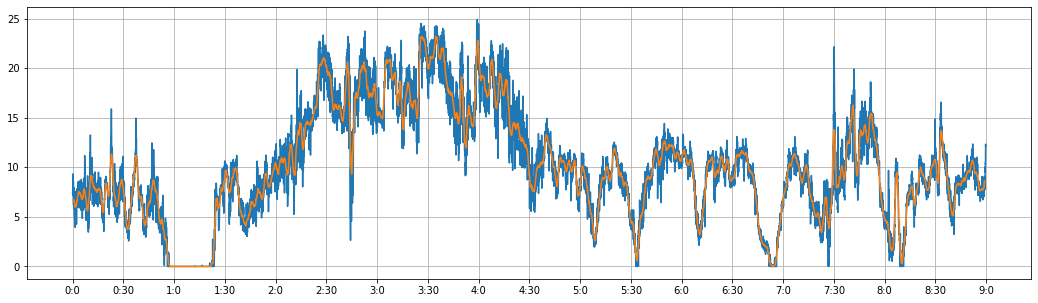

In [594]:
test_preds['rolling35'] = test_preds.avg.rolling(35,center=True).mean()

# fill forward and backward
test_preds.fillna(method='ffill', inplace=True)
test_preds.fillna(method='bfill', inplace=True)

show_lines(cols=[test_preds.avg, test_preds.rolling35])

### Surgery

In [687]:
tdf['edits'] = tdf.avg

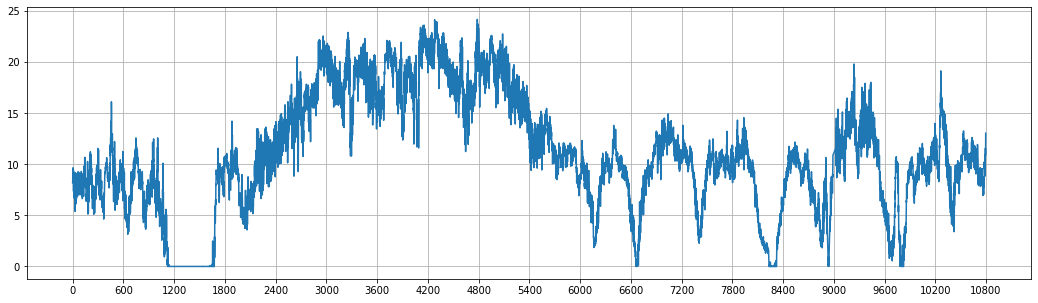

In [709]:
show_lines(cols=[tdf.edits], time=False)

In [701]:
def clear(start, end, df=tdf, col='edits'):
    df.loc[range(start,end+1), col] = np.NaN
    df[col] = df[col].interpolate()
    
def revert(start, end, df=tdf, col='edits'):
    df.loc[range(start,end+1), col] = df.avg[start:end+1].values
    df[col] = df[col].interpolate()

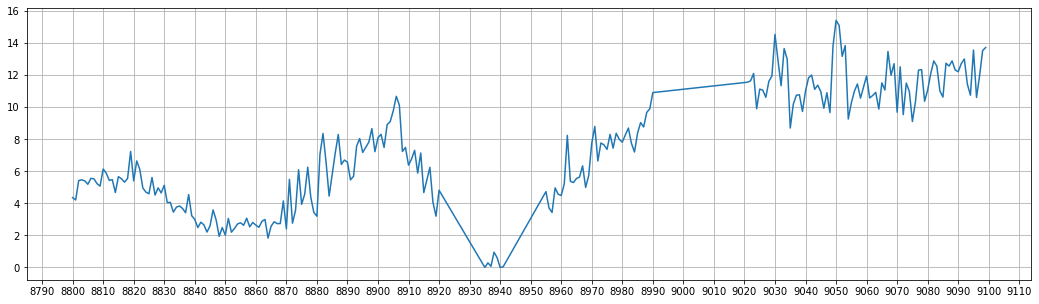

In [708]:
show_lines(start=8800, stop=9100, cols=[tdf.edits], time=False, ticks=10)

In [707]:
clear(8991,9020)

In [706]:
tdf.edits[8990:9027]

8990    10.895344
8991     9.751335
8992    13.573308
8993    11.918028
8994    14.082461
8995    13.740423
8996    13.526703
8997    15.288017
8998    14.755306
8999    16.719825
9000    16.161143
9001    15.060033
9002    17.918813
9003    15.434144
9004    17.917317
9005    20.724340
9006    19.314455
9007    17.823819
9008    17.114048
9009    14.355341
9010    14.707161
9011    14.101736
9012    14.047896
9013    14.213080
9014    16.721477
9015    14.508561
9016    13.603359
9017    12.502425
9018    13.473504
9019    10.554253
9020    11.380119
9021    11.541130
9022    11.624198
9023    12.086411
9024     9.886854
9025    11.110625
9026    11.048593
Name: edits, dtype: float64

## Smoothing

### Clip limit

In [286]:
lim = []
prv = None
for nxt in test_preds.edits:
    if prv:
        if np.mean([prv,nxt]) > 0.5: nxt = np.clip(nxt, prv-0.25, prv+0.25) 
    lim.append(nxt)
    prv = nxt

In [287]:
len(lim)

10798

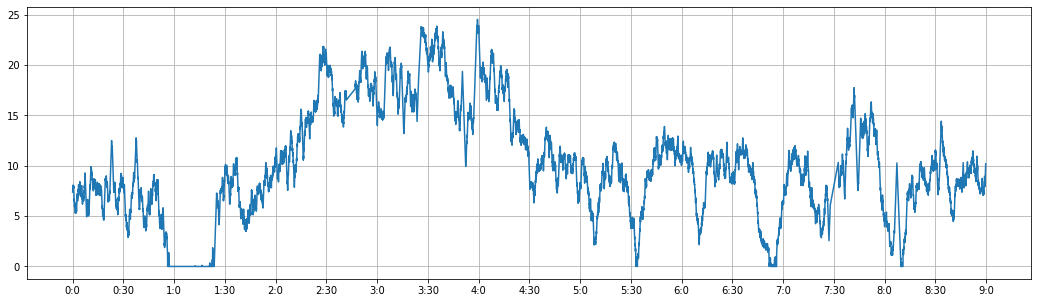

In [293]:
show_lines(cols=[lim])

### linear regresssion

In [381]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

In [210]:
lnr = LinearRegression()

In [311]:
lnr.fit(df[['rolling35', 'rolling_var']].values, df.labels.values)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [312]:
lns = lnr.predict(df[['rolling35', 'rolling_var']].values)

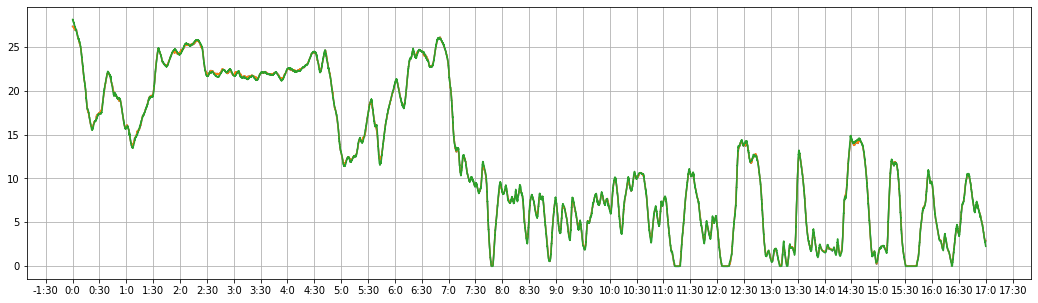

In [313]:
show_lines(cols=[lns, df.rolling35, df.labels])

In [314]:
mse(torch.from_numpy(lns), torch.from_numpy(df.labels.values))

tensor(0.0287, dtype=torch.float64)

In [211]:
knr = KNeighborsRegressor(n_neighbors=20)

In [212]:
knr.fit(df[['preds', 'rolling35', 'rolling_var', 'stable']].values, df.labels.values)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                    weights='uniform')

In [213]:
kks = knr.predict(df[['preds', 'rolling35', 'rolling_var', 'stable']].values)

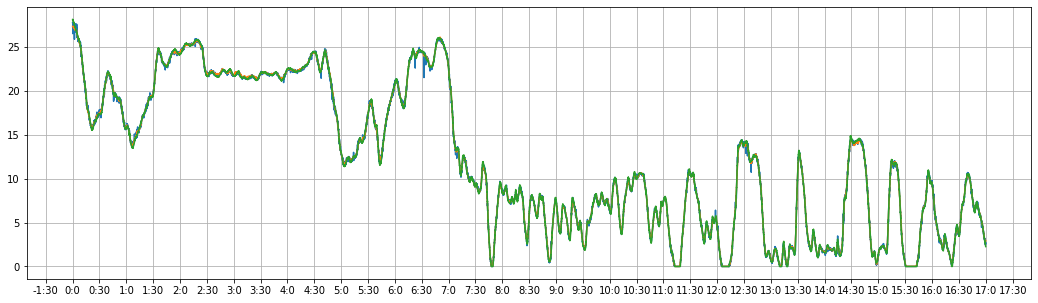

In [214]:
show_lines(cols=[kks, df.rolling35, df.labels])

In [215]:
mse(torch.from_numpy(kks), torch.from_numpy(df.labels.values))

tensor(0.0312, dtype=torch.float64)

In [305]:
test_lns = lnr.predict(test_preds[['avg', 'rolling35', 'rolling_var', 'stable']].values)

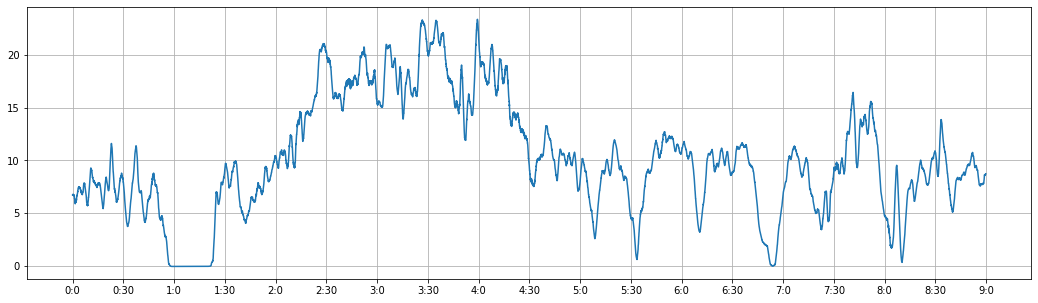

In [306]:
show_lines(cols=[test_lns])

### Polynomial Ridge Regression

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    model = make_pipeline(PolynomialFeatures(poly), Ridge())
    x = np.arange(len(data)).reshape(-1,1)
    model.fit(x, data)
    y = model.predict(x)

In [605]:
import warnings

def fit_curve(data, poly=10, plot=False, **kwargs):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model = make_pipeline(PolynomialFeatures(poly), Ridge())
        x = np.arange(len(data)).reshape(-1,1)
        model.fit(x, data)
        y = model.predict(x)
        if plot: show_lines(cols=[data, y], **kwargs)
        return y

In [606]:
# rolling regression over window: 100+-overlap
def rolling_ridge_regression(arr, window=100, offset=20, **kwargs):
    lst = []
    steps = list(range(0,len(arr)+window,window))
    for a,b in zip(steps[::],steps[1::]):
        a_off = offset if a > 0 else 0
        res = fit_curve(arr[a-a_off:b+offset], **kwargs)
        if b < len(arr):
            lst.append(res[a_off:-offset])
        else:
            lst.append(res[a_off:])
    return np.concatenate(lst)

In [780]:
tdf['ridge'] = rolling_ridge_regression(tdf.edits)

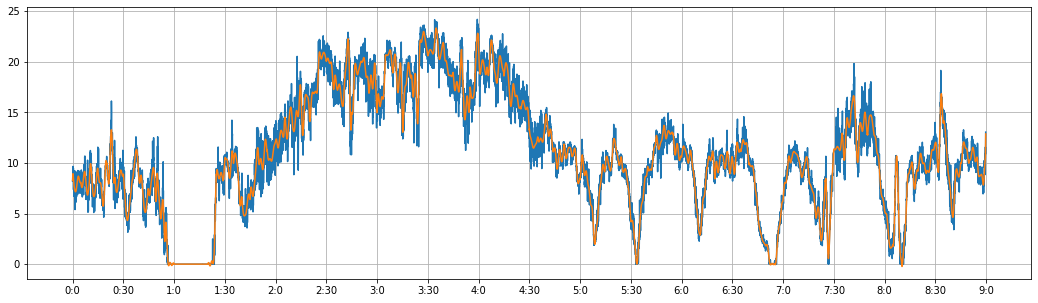

In [781]:
show_lines(cols=[tdf.edits, tdf.ridge])

In [810]:
np.savetxt(PATH/'test.txt', res, fmt='%.6f')

In [811]:
results = np.loadtxt(PATH/'test.txt')
len(results)

10798

### Combo of 10 and 9 w/ clipped mean average

In [639]:
t10 = pd.read_csv(PATH/'test_preds10.csv')
t9 = pd.read_csv(PATH/'test_preds9.csv')

In [640]:
tdf = pd.concat([t10,t9], axis=1)

In [641]:
tdf.head()

0         1         2         3         4         0          1  \
0  8.557017  7.121409  8.351146  5.935464  6.914673  8.221515   8.843656   
1  8.557017  7.121409  8.351146  5.935464  6.914673  8.221515   8.843656   
2  8.582624  8.208688  7.340874  7.624637  6.731520  8.923962   9.764938   
3  8.966945  7.013022  8.161030  6.445688  7.200841  9.729422  10.993324   
4  9.173439  7.401261  8.074786  7.475719  8.273556  8.321152   9.777439   

           2          3          4  
0   9.261274   8.406416   9.430629  
1   9.261274   8.406416   9.430629  
2  10.488605   9.711142  10.786326  
3  11.366283  11.012054  10.758749  
4   8.217974   9.887566  10.296509

In [660]:
def clipped_mean(row): return np.sort(row.values)[1:-1].mean()
tdf['avg'] = tdf.apply(clipped_mean, axis=1)

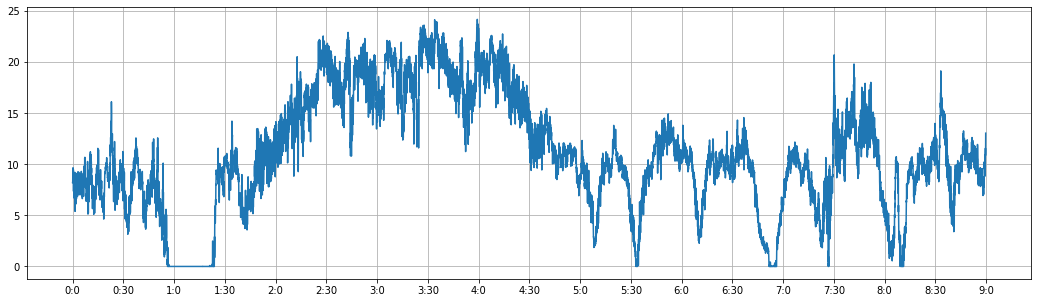

In [664]:
show_lines(cols=[tdf.avg])

# x4

## Val Preds

In [48]:
val_preds = pd.read_csv(PATH/'val_preds11.csv')

In [49]:
# separate preds(x4) into columns and take avg; add in targs
arr = []
for i in range(4):
    arr.append(val_preds.preds.values[i::4][:20400])
df = pd.DataFrame(np.stack(arr, axis=1))

In [50]:
df['avg'] = df.mean(axis=1)
df['labels'] = speeds

df['rolling35'] = df.avg.rolling(35,center=True).mean()

# fill forward and backward
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)

In [51]:
df.head()

0          1          2          3        avg     labels
0  28.323687  28.294603  28.361269  28.403479  28.345759  28.105569
1  28.130003  28.119297  28.082010  28.118520  28.112458  28.105569
2  28.212320  28.212732  28.204617  28.187166  28.204209  28.106527
3  28.584484  28.593174  28.450783  28.361948  28.497597  28.130404
4  28.069792  28.052055  28.067533  27.863615  28.013249  28.109243

In [55]:
mse(torch.from_numpy(df.avg.values), torch.from_numpy(df.labels.values))

tensor(0.0384, dtype=torch.float64)

In [56]:
mse(torch.from_numpy(df.rolling35.values), torch.from_numpy(df.labels.values))

tensor(0.0106, dtype=torch.float64)

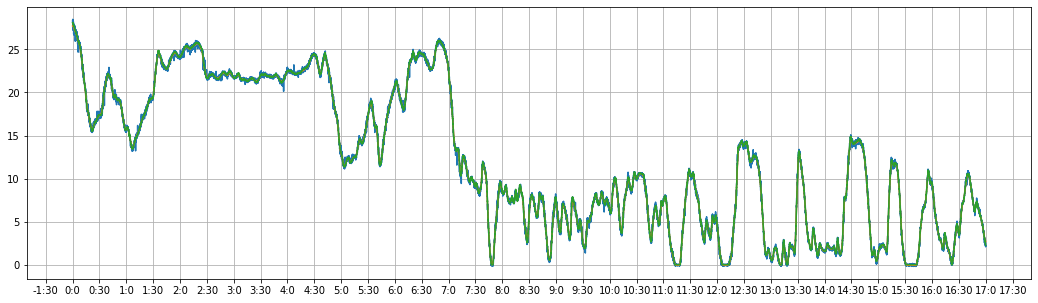

In [70]:
show_lines(cols=[df.avg, df.rolling35, df.labels])

## Test Preds

In [57]:
test_preds = pd.read_csv(PATH/'test_preds11.csv')
test_preds['avg'] = test_preds.mean(axis=1)   # take average of kfolds
len(test_preds)

43192

In [60]:
# separate preds(x4) into columns
arr = []
for i in range(4):
    arr.append(test_preds.avg.values[i::4])
tdf = pd.DataFrame(np.stack(arr, axis=1))

In [62]:
tdf['avg'] = tdf.mean(axis=1)
tdf.head()

0         1         2         3       avg
0  8.643805  8.958840  9.339354  9.114946  9.014236
1  8.643805  8.958840  9.339354  9.114946  9.014236
2  8.721175  8.655449  8.248218  8.492375  8.529304
3  8.336289  8.370394  7.664882  7.675530  8.011774
4  8.602361  8.792049  8.650710  8.589858  8.658744

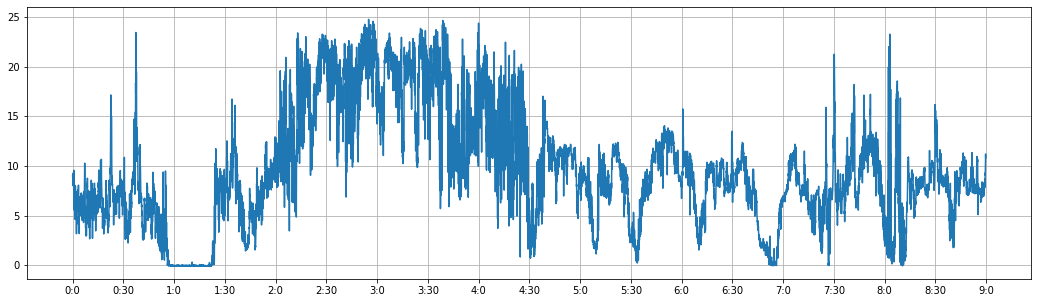

In [69]:
show_lines(cols=[tdf.avg])